In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pickle
sns.set()

In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
references = pd.read_csv("../data/references.csv").dropna()
show(references)
references.head(10)

(5241, 3)


,global_reference_id,title,abstract
0,0,Distributed Representations of Words and Phras...,The recently introduced continuous Skip-gram m...
1,1,BERT: Pre-training of Deep Bidirectional Trans...,We introduce a new language representation mod...
2,2,Attention Is All You Need,The dominant sequence transduction models are ...
3,3,GloVe : Global Vectors for Word Representation,Recent methods for learning vector space repre...
4,4,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-orde..."
6,6,Deep Contextualized Word Representations,We introduce a new type of deep contextualized...
7,7,Neural Machine Translation By Jointly Learning...,Neural machine translation is a recently propo...
8,8,Efficient Estimation of Word Representations i...,We propose two novel model architectures for c...
9,9,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...
11,11,Distributed Representations of Sentences and D...,Many machine learning algorithms require the i...


In [4]:
papers = pd.read_csv("../data/papers.csv")
show(papers)

(1091, 4)


,paper_id,title,abstract,text
0,0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


In [5]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,global_reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,475,Different from many other ranking methods whic...,216,219
2,0,5,155,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,25,The proposed model is based on the pointer-gen...,59,62
4,0,6,25,"Following [7], we also use a soft switch to ch...",10,13


# retrieving sentences

In [6]:
query_papers = citations.paper_id.value_counts().reset_index()\
.rename(columns = {"index":"paper_id", "paper_id":"references"})\
.merge(papers.drop(columns = ["title", "abstract"]))
show(query_papers)

(1091, 3)


,paper_id,references,text
0,482,718,This survey provides a synthesis of existing w...
1,647,718,This survey provides a synthesis of existing w...
2,595,599,commercial world. To provide an overview of th...
3,650,563,1 Interactive Clustering: A Comprehensive Revi...
4,372,491,"In this survey, we provide a synthesis of exis..."


In [7]:
papers.query("paper_id == 191")

,paper_id,title,abstract,text
191,191,The Benefits of Word Embeddings Features for A...,This study investigates the use of unsupervise...,Active learning (AL) has recently received con...


In [8]:
query_references = citations.global_reference_id.value_counts()\
.reset_index()\
.rename(columns = {"index":"global_reference_id", "global_reference_id":"citations"})\
.merge(references.dropna().drop(columns = "title"), right_index = True, left_on = "global_reference_id")
show(query_references)

(4193, 5)


,global_reference_id,global_reference_id_x,citations,global_reference_id_y,abstract
0,1,1,497,1,We introduce a new language representation mod...
1,2,2,257,2,The dominant sequence transduction models are ...
2,0,0,247,0,The recently introduced continuous Skip-gram m...
3,3,3,215,3,Recent methods for learning vector space repre...
4,8,8,184,8,We propose two novel model architectures for c...


In [9]:
query_citations = citations.merge(query_references)[["paper_id", "global_reference_id"]].drop_duplicates()
show(query_citations)

(11310, 2)


,paper_id,global_reference_id
0,0,1
2,7,1
6,8,1
12,12,1
18,17,1


In [10]:
# tokenizer = PunktSentenceTokenizer()
tokenizer = PunktSentenceTokenizer(train_text = papers.text.sum())
tokenizer

In [11]:
# model = CountVectorizer()
model = TfidfVectorizer()
model.fit(query_references.abstract)

TfidfVectorizer()

In [12]:
query_embeddings = model.transform(query_references.abstract)
print(query_embeddings.shape)

(4193, 16618)


In [13]:
sentence_embeddings = []
for p in tqdm(query_papers.text):
    s = tokenizer.tokenize(p)
    sentence_embeddings.append((np.array(s), model.transform(s)))
print(len(sentence_embeddings))
print(len(sentence_embeddings[0][0]), sentence_embeddings[0][1].shape)

  0%|          | 0/1091 [00:00<?, ?it/s]

1091
5973 (5973, 16618)


In [14]:
query_ids = query_references\
.global_reference_id\
.reset_index(drop = True)\
.reset_index()\
.set_index("global_reference_id")["index"]
show(query_ids)

(4193,)


global_reference_id
1    0
2    1
0    2
3    3
8    4
Name: index, dtype: int64

In [15]:
paper_ids = query_papers\
.paper_id\
.reset_index(drop = True)\
.reset_index()\
.set_index("paper_id")["index"]
show(paper_ids)

(1091,)


paper_id
482    0
647    1
595    2
650    3
372    4
Name: index, dtype: int64

In [16]:
data = query_citations.to_dict("records")#[:5]
sentence_scores = []
for d in tqdm(data):
    paper = d["paper_id"]
    reference = d["global_reference_id"]
    qe = query_embeddings[query_ids[reference]]
    sentences, embeddings = sentence_embeddings[paper_ids[paper]]
#     print(qe.shape)
#     print(embeddings.shape)
#     sim = cosine_similarity(qe.toarray(), embeddings.toarray()).flatten()
#     sim = (qe.toarray() @ embeddings.toarray().T).flatten()
    sim = (qe @ embeddings.T).toarray().flatten()
    df = pd.DataFrame({"text":sentences, "relevance_to_query":sim})\
    .assign(paper_id = paper, global_reference_id = reference)
    sentence_scores.append(df)
sentence_scores = pd.concat(sentence_scores, axis = 0)
show(sentence_scores)

  0%|          | 0/11310 [00:00<?, ?it/s]

(7185246, 4)


,text,relevance_to_query,paper_id,global_reference_id
0,"KEYWORDS cascade ranking, pre-trained language...",0.042176,0,1
1,2020.,0.000000,0,1
2,IDST at TREC 2019 Deep Learning Track: Deep Ca...,0.075402,0,1
3,In Proceedings of ACM Conference (Conference’17).,0.004060,0,1
4,"ACM, New York, NY, USA, 4 pages.",0.010899,0,1


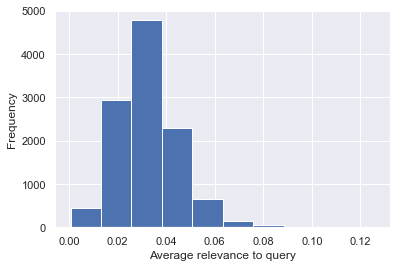

In [81]:
sentence_scores.groupby(["paper_id", "global_reference_id"]).relevance_to_query.mean().plot.hist()
plt.xlabel("Average relevance to query")
plt.show()

In [82]:
queries = sentence_scores.query("relevance_to_query > 0.1")\
.groupby(["paper_id", "global_reference_id"])\
.text.sum()\
.to_frame()\
.reset_index()\
.merge(references.drop(columns = ["title"]))\
.rename(columns = {"text":"hypothesis", "abstract":"reference"})\
.dropna()\
.reset_index(drop = True)

show(queries)

(4949, 4)


,paper_id,global_reference_id,hypothesis,reference
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...
1,7,1,Their success is attributed to their use of bi...,We introduce a new language representation mod...
2,8,1,"BERT K-means clustering), both uncertainty and...",We introduce a new language representation mod...
3,12,1,NER acts as an important pre-processing step f...,We introduce a new language representation mod...
4,17,1,"In particular, Bidirectional Encoder Represent...",We introduce a new language representation mod...


# rouge

In [83]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

4949


[{'rouge-1': {'r': 0.3482142857142857,
   'p': 0.13541666666666666,
   'f': 0.19499999596800008},
  'rouge-2': {'r': 0.04929577464788732,
   'p': 0.012455516014234875,
   'f': 0.01988636041596772},
  'rouge-l': {'r': 0.33035714285714285,
   'p': 0.1284722222222222,
   'f': 0.18499999596800007}},
 {'rouge-1': {'r': 0.2767857142857143,
   'p': 0.11654135338345864,
   'f': 0.1640211598510681},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.26785714285714285,
   'p': 0.11278195488721804,
   'f': 0.1587301545600628}},
 {'rouge-1': {'r': 0.26785714285714285,
   'p': 0.16042780748663102,
   'f': 0.20066889163566415},
  'rouge-2': {'r': 0.014084507042253521,
   'p': 0.006472491909385114,
   'f': 0.008869175286455951},
  'rouge-l': {'r': 0.25, 'p': 0.1497326203208556, 'f': 0.18729096521425945}},
 {'rouge-1': {'r': 0.5089285714285714,
   'p': 0.22440944881889763,
   'f': 0.31147540558870074},
  'rouge-2': {'r': 0.2676056338028169,
   'p': 0.08656036446469248,
   'f': 0.1308089

In [84]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(4949, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.3482142857142857, 'p': 0.1354166666666...","{'r': 0.04929577464788732, 'p': 0.012455516014...","{'r': 0.33035714285714285, 'p': 0.128472222222..."
1,"{'r': 0.2767857142857143, 'p': 0.1165413533834...","{'r': 0.0, 'p': 0.0, 'f': 0.0}","{'r': 0.26785714285714285, 'p': 0.112781954887..."
2,"{'r': 0.26785714285714285, 'p': 0.160427807486...","{'r': 0.014084507042253521, 'p': 0.00647249190...","{'r': 0.25, 'p': 0.1497326203208556, 'f': 0.18..."
3,"{'r': 0.5089285714285714, 'p': 0.2244094488188...","{'r': 0.2676056338028169, 'p': 0.0865603644646...","{'r': 0.5, 'p': 0.2204724409448819, 'f': 0.306..."
4,"{'r': 0.375, 'p': 0.15384615384615385, 'f': 0....","{'r': 0.09154929577464789, 'p': 0.028260869565...","{'r': 0.30357142857142855, 'p': 0.124542124542..."


In [85]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(4949, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.348214,0.135417,0.195000
1,0.276786,0.116541,0.164021
2,0.267857,0.160428,0.200669
3,0.508929,0.224409,0.311475
4,0.375000,0.153846,0.218182


In [86]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(4949, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.049296,0.012456,0.019886
1,0.000000,0.000000,0.000000
2,0.014085,0.006472,0.008869
3,0.267606,0.086560,0.130809
4,0.091549,0.028261,0.043189


In [87]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(4949, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.330357,0.128472,0.185000
1,0.267857,0.112782,0.158730
2,0.250000,0.149733,0.187291
3,0.500000,0.220472,0.306011
4,0.303571,0.124542,0.176623


In [88]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(4949, 13)


,paper_id,global_reference_id,hypothesis,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...,0.348214,0.135417,0.195000,0.049296,0.012456,0.019886,0.330357,0.128472,0.185000
1,7,1,Their success is attributed to their use of bi...,We introduce a new language representation mod...,0.276786,0.116541,0.164021,0.000000,0.000000,0.000000,0.267857,0.112782,0.158730
2,8,1,"BERT K-means clustering), both uncertainty and...",We introduce a new language representation mod...,0.267857,0.160428,0.200669,0.014085,0.006472,0.008869,0.250000,0.149733,0.187291
3,12,1,NER acts as an important pre-processing step f...,We introduce a new language representation mod...,0.508929,0.224409,0.311475,0.267606,0.086560,0.130809,0.500000,0.220472,0.306011
4,17,1,"In particular, Bidirectional Encoder Represent...",We introduce a new language representation mod...,0.375000,0.153846,0.218182,0.091549,0.028261,0.043189,0.303571,0.124542,0.176623


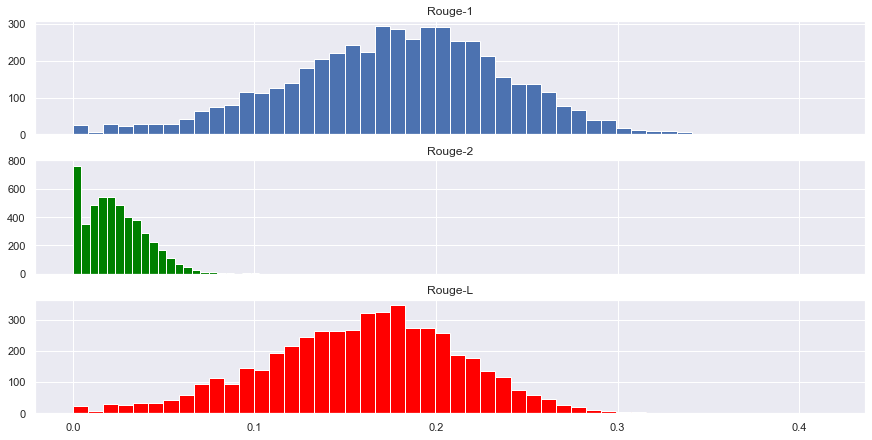

In [89]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

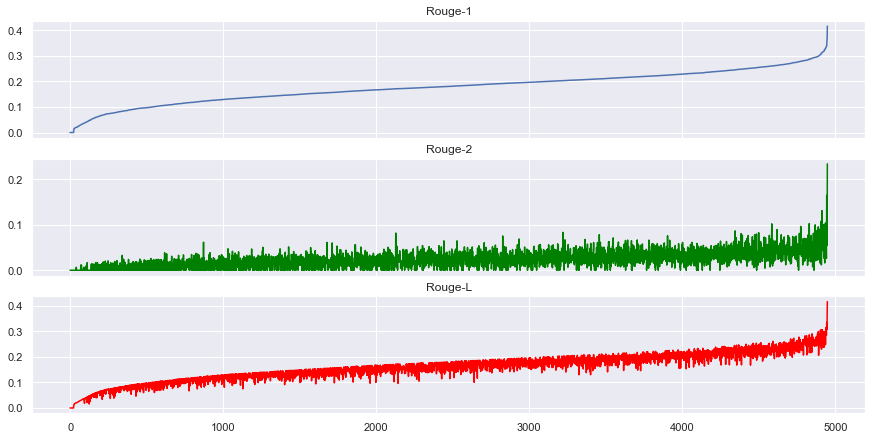

In [90]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

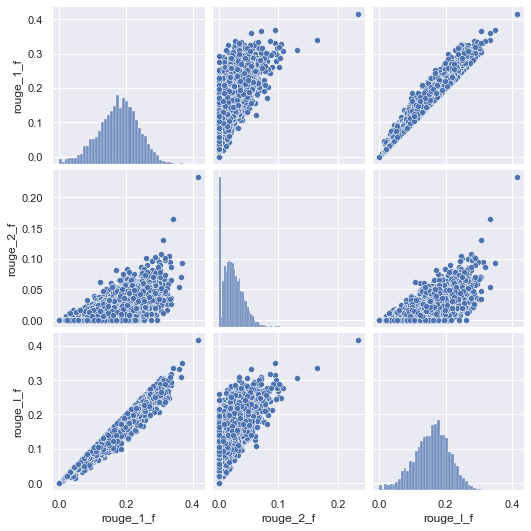

In [91]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

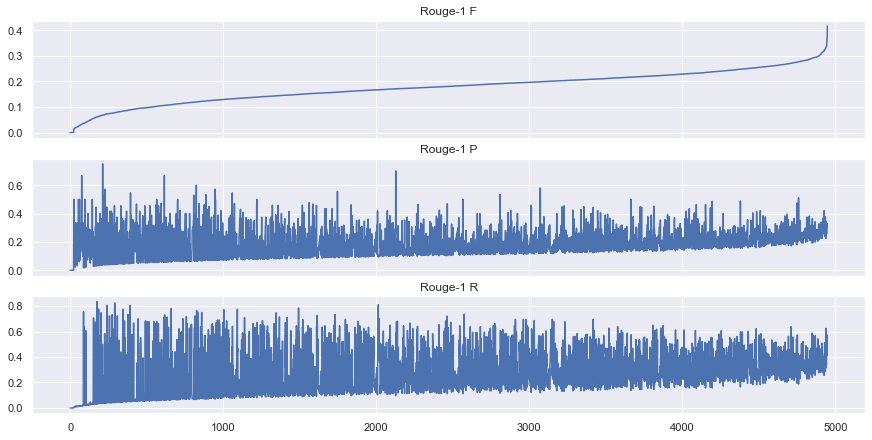

In [92]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

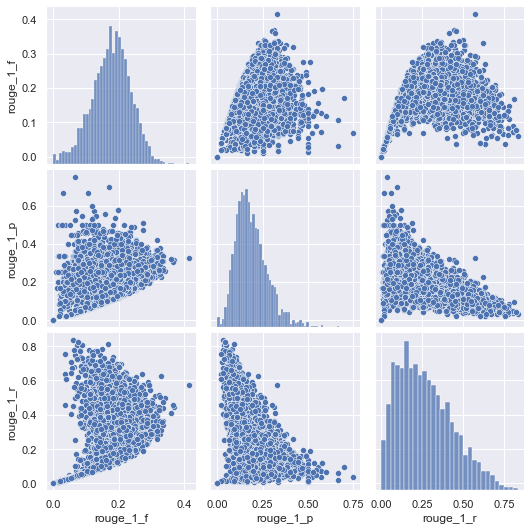

In [93]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

# inspection

## worse

In [94]:
full_rouge.sort_values("rouge_1_f").head()

,paper_id,global_reference_id,hypothesis,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
3383,562,506,The objective function is split into three terms.,How can end users efficiently influence the pr...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4046,350,1435,"): Explainable AI, LNAI 11700, pp.",This paper provides an entry point to the prob...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4075,278,5695,", ttokn where n = 511.+ (xvjW K v aij)︸ ︷︷ ︸ k...","For understanding generic documents, informati...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,248,87,"For example, Joshi et al.Recently, Elhamifar e...",The ImageNet Large Scale Visual Recognition Ch...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4425,415,16123,Cazabet et al.Ma et al.Nguyen et al.Lin et al....,A community within a network is a group of ver...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
full_rouge.sort_values("rouge_1_f").head().hypothesis.tolist()

['The objective function is split into three terms.',
 '): Explainable AI, LNAI 11700, pp.',
 ', ttokn where n = 511.+ (xvjW K v aij)︸ ︷︷ ︸ key 1D relative attn.',
 'For example, Joshi et al.Recently, Elhamifar et al.',
 'Cazabet et al.Ma et al.Nguyen et al.Lin et al.Lancichinetti et al.Raghavan et al.Gregory et al.Xie et al.Aston et al.']

In [96]:
full_rouge.sort_values("rouge_1_f").head().reference.tolist()

['How can end users efficiently influence the predictions that machine learning systems make on their behalf? This paper presents Explanatory Debugging, an approach in which the system explains to users how it made each of its predictions, and the user then explains any necessary corrections back to the learning system. We present the principles underlying this approach and a prototype instantiating it. An empirical evaluation shows that Explanatory Debugging increased participants’ understanding of the learning system by 52% and allowed participants to correct its mistakes up to twice as efficiently as participants using a traditional learning system.',
 'This paper provides an entry point to the problem of interpreting a deep neural network model and explaining its predictions. It is based on a tutorial given at ICASSP 2017. It introduces some recently proposed techniques of interpretation, along with theory, tricks and recommendations, to make most efficient use of these techniques 

## best

In [97]:
full_rouge.sort_values("rouge_1_f", ascending = False).head()

,paper_id,global_reference_id,hypothesis,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
13,71,1,Different from the absolute 2-D position embed...,We introduce a new language representation mod...,0.571429,0.326531,0.415584,0.373239,0.169872,0.233480,0.571429,0.326531,0.415584
1504,167,20,"First, we use a language modeling objective on...",We propose a unified neural network architectu...,0.445783,0.313559,0.368159,0.123711,0.075472,0.093750,0.421687,0.296610,0.348259
1537,1061,20,"For example, reliance on the handcrafted featu...",We propose a unified neural network architectu...,0.457831,0.304000,0.365385,0.103093,0.053476,0.070423,0.385542,0.256000,0.307692
1753,883,31,"To do this, we can first use human labels to t...",We present two approaches that use unlabeled d...,0.411765,0.318182,0.358974,0.070423,0.044444,0.054496,0.382353,0.295455,0.333333
68,448,1,"Firstly, to better capture sentential meaning ...",We introduce a new language representation mod...,0.500000,0.258065,0.340426,0.267606,0.118750,0.164502,0.491071,0.253456,0.334347


In [98]:
full_rouge.sort_values("rouge_1_f", ascending = False).head().hypothesis.tolist()

['Different from the absolute 2-D position embeddings, the relative position embeddings explicitly provide a broader view for the contextual spatial modeling.However, the original self-attention mechanism can only implicitly capture the relationship between the input tokens with the absolute position hints.The entity-level F1 score is used as the evaluation metric.In the DocVQA paper, experiment results show that the BERT model fine-tuned on the SQuAD dataset (Rajpurkar et al., 2016) outperforms the original BERT model.The QG dataset contains almost one million question-answer pairs generated by a generation model trained on the SQuAD dataset.For text-only models, the UniLMv2 models outperform the BERT models by a large margin in terms of the BASE and LARGE settings.The best performance is achieved by the LayoutLMv2LARGE, where an improvement of 3% F1 point is observed compared to the current SOTA results.The LayoutLM family significantly outperforms the text-only pre-trained models in

In [99]:
full_rouge.sort_values("rouge_1_f", ascending = False).head().reference.tolist()

['We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 poin

# final performance

In [100]:
full_rouge[["rouge_1_f", "rouge_2_f", "rouge_l_f"]].describe(percentiles = np.linspace(0, 1, 11))

,rouge_1_f,rouge_2_f,rouge_l_f
count,4949.000000,4949.000000,4949.000000
mean,0.176852,0.023526,0.159016
std,0.059784,0.017810,0.053844
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
10%,0.096552,0.000000,0.085960
20%,0.128319,0.008183,0.114844
30%,0.147940,0.012821,0.132869
40%,0.166205,0.017291,0.148342
50%,0.179894,0.021505,0.162602
